In [1]:
#from docutils.languages.zh_cn import labels
from docutils.nodes import legend
from sympy import rotations
from sympy.abc import alpha
from sympy.printing.pretty.pretty_symbology import line_width
import matplotlib.patches as mpatches


from src.ign_moveit2_examples.examples.py.analyse_data import color


# parts: 'cube' 'nt39'

part = 'cube'


if part == 'cube':
    cfg_reevaluate_success_params = part
    fn = '/home/klaus/code/pymi2_ws/sim_data/out/testdata_v2_1k.dill'
    
if part == 'nt39':
    cfg_reevaluate_success_params = None
    fn = '/home/klaus/code/pymi2_ws/sim_data/out/testdata_nt39_v2_1k.dill'

# setup reevaluation distance threshold and rotation penalty
reevaluation_params = {}
reevaluation_params['cube'] = (0.025,0)  # dist_threshold_m, rad_per_m
reevaluation_params['nt39'] = (0.05,0.1)  # dist_threshold_m, rad_per_m

#DataFile

#plot putput
figurefolder = '/home/klaus/code/pymi2_ws/sim_data/figures'

# reshuffle data this many times and relearn it (to plot average, deviation etc)
cfg_reshuffle_count = 9 

# stop learning after a certain amount of actions 
cfg_stop_learning_after_n_trials = 0

cfg_ignore_confusion_before_n_trials = cfg_stop_learning_after_n_trials
cfg_ignore_confusion_before_n_trials = 0
# check prediction accuracy only after n actions
cfg_ignore_accuracy_before_n_trials = cfg_stop_learning_after_n_trials
cfg_ignore_accuracy_before_n_trials = 100

cfg_n_bins = 10
cfg_bEqualBinSize = True # True have nearly equal amount of samples per bin, False: have equally wide bin intervals 
cfg_bMedianPrediction = True # Use median instead of mean for each bin's reported prediction

cfg_bSaveFigures = True



['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']


In [2]:
# in case of error:
# activate venv: "source venv/bin/activate"
# run "python -m ipykernel install --user --name=venv_pymi2
# select kernel in jupyter

In [3]:
import sys
import data_utils
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import math
import numpy as np
from math3d import (Transform, Orientation, PositionVector, Versor)
import classify
import random
from pathlib import Path
import analyse_data as ad

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']


In [4]:
ad.fn = fn
ad.figurefolder = figurefolder


In [5]:
colours = {'blue':'#2c628cff',
           'yellow':'#ffb72dff',
           'red':'#c40900ff',
           'green':'#369424ff',
           'purple':'#8c00c0ff',
           'orange':'#ea6e00ff',
           'neutral':'#fbe5bcff',
           'background':'#fdf7edff',
           'black':'#000000ff'
           }

coloursdark = {'blue':'#00335cff',
           'yellow':'#996500ff',
           'red':'#610400ff',
           'green':'#1b4a12ff',
           'purple':'#470061ff',
           'orange':'#7a3a00ff',
           'neutral':'#e8ae6dff',
           'background':'#fdf7edff',
           'black':'#000000ff'
           }

colourslight= {'blue':'#65a1cdff',
           'yellow':'#fed17aff',
           'red':'#db685fff',
           'green':'#85bc75ff',
           'purple':'#b963d2ff',
           'orange':'#f1a55fff',
           'neutral':'#fcecd0ff',
           'background':'#fdf7edff',
           'black':'#333333ff'
           }


def calpha(sclr,alphahex):
         l = len(sclr)
         if l == 9:
             return sclr[:7]+alphahex
         if l == 7:
             return sclr+alphahex 
             
             
         
# TODO? implement easy way to lighten darken colors:
# https://stackoverflow.com/a/13542669
# https://github.com/PimpTrizkit/PJs/wiki/12.-Shade,-Blend-and-Convert-a-Web-Color-(pSBC.js)

In [6]:
# Uncomment for white-background figures
#mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = colours['background']

# Make graphs appear larger
plt.rcParams['figure.dpi'] = 200

# Change font
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

pd.set_option("display.precision", 2)

def figsave(plot_axis,prefix):
    if not cfg_bSaveFigures:
        return plot_axis
    p = Path(figurefolder)        
    Path.mkdir(p, parents=True, exist_ok=True)
    
    def figp(counter,ext):
        return p / f'{part}_{prefix}_{counter}.{ext}'
    
    i = 1
    fn = figp(i,'svg')
    fn_v = figp(i,'pdf')
    fn_b = figp(i,'png')
    while fn.exists():
        i+=1
        fn = figp(i,'svg')
        fn_v = figp(i,'pdf')
        fn_b = figp(i,'png')
        
    plot_axis.figure.savefig(fn)
    plot_axis.figure.savefig(fn_b)
    plot_axis.figure.savefig(fn_v,format='pdf')

    return plot_axis

In [7]:
# (clear) datalists
dl_seeds_int = [] # random seeds when reshuffled
dl_confusion_matrices_obj = [] # confusion matrix for prediction (including learning) 
dl_correct_prediction_ratios_over_n_pd = [] # 
dl_success_rates_vs_probability_predicted_pd = []
dl_success_rates_intervals_not_binned_pd = []
    
def clear_data():
    dl_seeds_int.clear()
    dl_confusion_matrices_obj.clear() 
    dl_correct_prediction_ratios_over_n_pd.clear() 
    dl_success_rates_vs_probability_predicted_pd.clear()
    dl_success_rates_intervals_not_binned_pd.clear()

In [8]:
tf_lookup = {True: 1.0, False: 0.0}

def get_succ_prob(pred_prob_list):
    if len(pred_prob_list) <1 :
        return None
    if True in pred_prob_list:
        return pred_prob_list[True]
    else:
        return 1.0-pred_prob_list[False]

def relearn_and_get_data(simdata,bShuffle=False,bPrint=True,bProbabilityPred=True):
    
    clf = classify.Classifyer()
    clf.resetConfusion()
    
    predicted_probability__iter = []
    result__iter = []
    
    if bShuffle:
        r_seed = random.randrange(sys.maxsize)
        if bPrint:
            print(f'Randomized list with seed: {r_seed}')
        dl_seeds_int.append(r_seed)
        random.seed(r_seed)
        random.shuffle(simdata)
    else:
        dl_seeds_int.append(0)
        
    learned_count = 0
    
    skipped_no_outcome = 0

    for e in simdata:
        assert isinstance(e, data_utils.DataEntry)
        if e.b_outcome is None:
            skipped_no_outcome +=1
            continue
            
        # actually reclassify success
        if cfg_reevaluate_success_params is not None:
            e.b_outcome = data_utils.pose_distance(data_utils.Transform(),e.final_pose_from_goal,reevaluation_params[cfg_reevaluate_success_params][1]) <= reevaluation_params[cfg_reevaluate_success_params][0] 
        
        pred = clf.predict(e.sampled_variance)
        pred_prob = clf.predict_prob(e.sampled_variance)
        outcome = e.b_outcome
        if learned_count < cfg_stop_learning_after_n_trials or cfg_stop_learning_after_n_trials < 1:
            clf.learn(e.sampled_variance, outcome)        
        learned_count += 1
        clf.storeOutcome(pred, outcome)
        
        if learned_count == cfg_ignore_confusion_before_n_trials and cfg_ignore_confusion_before_n_trials > 0:
            clf.resetConfusion()

        tmp = get_succ_prob(pred_prob)
        if tmp is not None:
            predicted_probability__iter.append(tmp)
            result__iter.append(tf_lookup[e.b_outcome])
            
    if bPrint:         
        print(f'Entries without outcome: {skipped_no_outcome}')
    
    pred_ratio_iterative = clf.get_equal_ratios().copy()
    
    dl_confusion_matrices_obj.append(ad.confusion_data_binary(clf.confusion,bPrint=bPrint))
    
    pd_correct_prediction_ratios = pd.DataFrame({ 'pred_cum_ratio_iter': pred_ratio_iterative})
    
    dl_correct_prediction_ratios_over_n_pd.append(pd_correct_prediction_ratios)        
    
    if not bProbabilityPred:
        dl_success_rates_vs_probability_predicted_pd.append(None)
        return
    
    pd_pred_probabilities_iter = pd.DataFrame(
        {
            'probability_predicted': predicted_probability__iter,
            'outcome': result__iter
        }
    )
        
    if cfg_ignore_accuracy_before_n_trials > 0:
        pd_binned_probabilities = pd_pred_probabilities_iter.copy()[cfg_ignore_accuracy_before_n_trials:]
    else:
        pd_binned_probabilities = pd_pred_probabilities_iter.copy()
    bin_labels = []
    for b in range(cfg_n_bins):
        bin_labels.append(str(b+1))

    if cfg_bEqualBinSize:
        # equal count in bin
        pd_binned_probabilities["interval"] = pd.qcut(pd_binned_probabilities['probability_predicted'],cfg_n_bins)
    else:
        # equal bin width
        pd_binned_probabilities["interval"]=pd.cut(pd_binned_probabilities['probability_predicted'],np.linspace(0,1, cfg_n_bins+1),right=True,include_lowest=True)
         
    dl_success_rates_intervals_not_binned_pd.append(pd_binned_probabilities) 
       
    pd_tmp = pd_binned_probabilities.groupby("interval",observed=True).mean()    
    if cfg_bMedianPrediction:
        pd_tmp["probability_predicted"] = pd_binned_probabilities.groupby("interval",observed=True).median()["probability_predicted"]
                
        
    pd_tmp["diff"] = pd_tmp["probability_predicted"] - pd_tmp["outcome"]
    pd_tmp['bins'] = bin_labels
    pd_tmp['n'] = pd_binned_probabilities.groupby("interval",observed=True).count()['outcome']
    pd_tmp['s'] = pd_binned_probabilities.groupby("interval",observed=True).sum()['outcome']
    pd_tmp['inter'] = pd_tmp.index
    
    statistics_prop_predicted = pd_binned_probabilities.groupby("interval",observed=True).describe()["probability_predicted"]
    
    pd_tmp.join(statistics_prop_predicted)

    pd_print = pd_tmp[['bins','inter','n','s','probability_predicted','outcome','diff']]
    if bPrint:
        print("statistics:")
        print(statistics_prop_predicted)
        print("text:") 
        print(pd_print.to_string(index=False))
        print("Latex:")
        print(pd_print.to_latex(index=False,decimal='.',float_format="%.2f"))
            
                      
         
    dl_success_rates_vs_probability_predicted_pd.append(pd_tmp)
        

In [9]:
clear_data()
simdata = ad.load_file(fn)

relearn_and_get_data(simdata,bShuffle=False,bPrint=True,bProbabilityPred=True)

for i in range(cfg_reshuffle_count):
    relearn_and_get_data(simdata,bShuffle=True, bPrint=False,bProbabilityPred=True)

#data_original = ad.data_2_pandas(simdata)

Entries without outcome: 0
------------------
      / Predicted
Act. /
        False   True  
False     150    244  
 True     120    485  
sum         : 999.0
succesfull interactions: 605.0
correct predictions: 635.0
accuracy    : 0.64
error       : 0.36
precision   : 0.67
recall      : 0.8
specificity : 0.38
------------------

statistics:
                                 count  mean       std       min   25%   50%  \
interval                                                                       
(0.00021999999999999993, 0.287]   90.0  0.18  8.54e-02  1.22e-03  0.11  0.21   
(0.287, 0.437]                    90.0  0.36  4.57e-02  2.87e-01  0.33  0.36   
(0.437, 0.551]                    90.0  0.49  3.28e-02  4.38e-01  0.47  0.49   
(0.551, 0.626]                    90.0  0.59  1.90e-02  5.51e-01  0.58  0.59   
(0.626, 0.677]                    90.0  0.65  1.38e-02  6.27e-01  0.64  0.65   
(0.677, 0.722]                    89.0  0.70  1.25e-02  6.78e-01  0.69  0.70   
(0.722, 0.764]  

<AxesSubplot: xlabel='Prediction Interval', ylabel='% Success'>

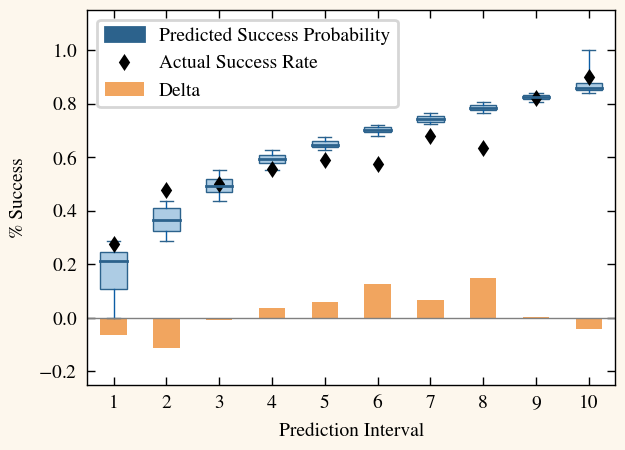

In [10]:
# learned probability prediction

# bars, boxplot
plottype = 'boxplot'
ax = plt.axes()
#ax.set_facecolor(colours['background'])


lbl_pred = 'Predicted Success Probability'
lbl_rate = 'Actual Success Rate'
lbl_diff = 'Delta'

if plottype == 'bars':
    dl_success_rates_vs_probability_predicted_pd[0].plot(x='bins', y=['probability_predicted', 'outcome', 'diff'], kind='bar', grid=False, color=[colours['blue'],colours['green'],colourslight['orange']],ax=ax)
    ax.set_ylim([-0.25, 1])
    ax.legend([lbl_pred,lbl_rate,lbl_diff])
    
if plottype == 'boxplot':
    #print(dl_success_rates_intervals_not_binned_pd[0].keys)
    
    th_whisk = 0.5
    th_box = 0.5
    clr='blue'        
    cl=colours
    b_width = 0.5

    box_legend = mpatches.Patch(color=cl[clr], label=lbl_pred)

     
    boxprops = dict(linestyle='-', linewidth=th_box, facecolor=calpha(colourslight[clr],'88'), edgecolor=cl[clr])
     
    box_dict = dl_success_rates_intervals_not_binned_pd[0].boxplot(column='probability_predicted',by='interval',ax=ax,whis=(0,100),return_type='dict',boxprops=boxprops, patch_artist=True, widths=b_width
)
    
    # remove autocaptions
    plt.title("")
    plt.suptitle("")
        
                        
    # set ticks
    tick_names=dl_success_rates_vs_probability_predicted_pd[0].bins.tolist()
    ticks=np.linspace(1,len(tick_names),len(tick_names))
    plt.xticks(ticks=ticks,labels=tick_names)
    
      
    # format boxplot
    bp = box_dict
    [[item.set_linewidth(th_box) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(th_whisk) for item in bp[key]['fliers']] for key in bp.keys()]
    #[[item.set_linewidth(4) for item in bp[key]['medians']] for key in bp.keys()]
    #[[item.set_linewidth(4) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(th_whisk) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(th_whisk) for item in bp[key]['caps']] for key in bp.keys()]
    
  #  [[item.set_color(cl[clr]) for item in bp[key]['boxes']] for key in bp.keys()]
  #  [[item.set_facecolor(cl[clr]) for item in bp[key]['boxes']] for key in bp.keys()]
  #  # seems to have no effect
  #  [[item.set_color(cl[clr]) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color(cl[clr]) for item in bp[key]['medians']] for key in bp.keys()]
  #  #[[item.set_markerfacecolor('k') for item in bp[key]['means']] for key in bp.keys()]
  #  [[item.set_color(cl[clr]) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color(cl[clr]) for item in bp[key]['caps']] for key in bp.keys()]
    
    
    # add outcome
    ax.plot(ticks,dl_success_rates_vs_probability_predicted_pd[0]['outcome'].tolist(),marker='d',color=colours['black'],linestyle='None',label=lbl_rate)
    
    # add delta
    ax.bar(ticks,dl_success_rates_vs_probability_predicted_pd[0]['diff'].tolist(),color=colourslight['orange'],label=lbl_diff,width=b_width)
    
    ax.set_ylim([-0.25, 1.15])
    
    # normal legend
    plt.legend()
    l_handles, l_lables = plt.gca().get_legend_handles_labels()

    # add / reorder
    ax.legend([box_legend, l_handles[0],l_handles[1]],[lbl_pred, l_lables[0],l_lables[1]],loc='upper left',frameon=True)
    ax.axhline(0, color='grey', linewidth=0.5)

        
    pass # end of boxplotting

ax.minorticks_off()

plt.grid(False)
plt.xlabel('Prediction Interval')
plt.ylabel('% Success')
plt.xticks(rotation=0)

pp_lbl = 'mean'
if cfg_bMedianPrediction:
    pp_lbl = 'median'
figsave(ax,f'fig_pred_probability_{pp_lbl}_{plottype}')


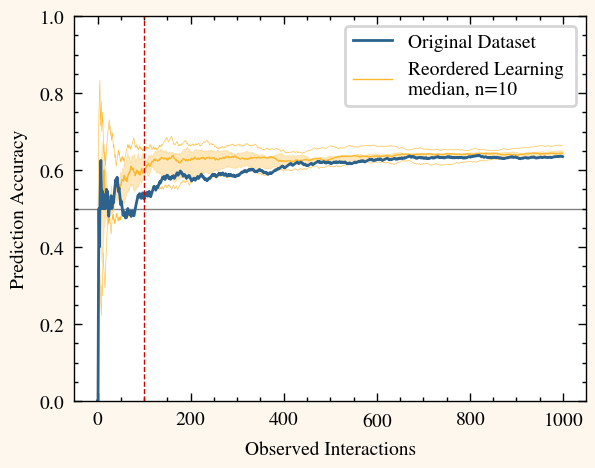

<AxesSubplot: xlabel='Observed Interactions', ylabel='Prediction Accuracy'>

In [11]:
# Learned Binary prediction Accuracy

c1 = 'blue'
c2 = 'yellow'
c3 = 'red'


bHasStatistic = cfg_reshuffle_count > 0


ax = plt.axes()
label_main = 'Original Dataset'

cfg_plot_type= 'single'

if bHasStatistic:
    # https://stackoverflow.com/questions/70454007/plotting-multiple-data-sets-as-one-average-and-adding-error-bars-matplotlib
    pd_all = pd.DataFrame()
    
    cfg_plot_type = 'boxPlot'
    
    statistics_plot_cfg = {
        'meanStd' : ['mean','m-std','m+std','min','max'],
        'boxPlot' : ['50%','25%','75%','min','max']
    }
    
    for i in range(cfg_reshuffle_count+1):
        pd_all[f'run_{i}']=dl_correct_prediction_ratios_over_n_pd[i][['pred_cum_ratio_iter']]
        
   # print(pd_all.T.describe())
        
    pd_all_info = pd_all.T.describe().T 
    pd_all_info['m-std']=pd_all_info['mean']-pd_all_info['std']
    pd_all_info['m+std']=pd_all_info['mean']+pd_all_info['std']
    
    pl_area_low = pd_all_info[statistics_plot_cfg[cfg_plot_type][1]]
    pl_area_high = pd_all_info[statistics_plot_cfg[cfg_plot_type][2]]
    pl_line_mid =  pd_all_info[statistics_plot_cfg[cfg_plot_type][0]]
    pl_line_low = pd_all_info[statistics_plot_cfg[cfg_plot_type][3]]
    pl_line_high = pd_all_info[statistics_plot_cfg[cfg_plot_type][4]]
    
    plt.fill_between(pd_all_info.index, y1=pl_area_low,y2=pl_area_high,color=colourslight[c2],alpha=0.5,linewidth=0.3)
    #plt.plot()
    #plt.plot(pd_all_info['mean']-pd_all_info['std'])
    plt.plot(pl_line_mid,color=colours[c2],linewidth=0.5,label="l1")
    plt.plot(pl_line_low,color=colours[c2],linewidth=0.2)
    plt.plot(pl_line_high,color=colours[c2],linewidth=0.2)
    
    lbl = statistics_plot_cfg[cfg_plot_type][0]
    if lbl == '50%':
        lbl = 'median'
    
    label_stat =  f'Reordered Learning \n{lbl}, n={cfg_reshuffle_count+1}'


    
plt.plot(dl_correct_prediction_ratios_over_n_pd[0][['pred_cum_ratio_iter']],color=colours[c1],label=label_main)

#dl_correct_prediction_ratios_over_n_pd[0][['pred_cum_ratio_iter']].plot()
if bHasStatistic:
    l_handles, l_lables = plt.gca().get_legend_handles_labels()
    ax.legend([l_handles[1],l_handles[0]],[label_main,label_stat],frameon=True)
else:
    ax.legend([label_main],frameon=True)

if cfg_ignore_accuracy_before_n_trials > 0:
    plt.plot([cfg_ignore_accuracy_before_n_trials,cfg_ignore_accuracy_before_n_trials],[0,1], label="line",linestyle='dashed',color=colours[c3],linewidth=0.5)

ax.set_ylim([0, 1])
ax.axhline(0.5, color='grey', linewidth=0.5, zorder=0)

#ax.minorticks_off()

plt.xlabel('Observed Interactions')
plt.ylabel('Prediction Accuracy')

plt.show()
    
figsave(ax,f'fig_pred_accuracy_{cfg_plot_type}')

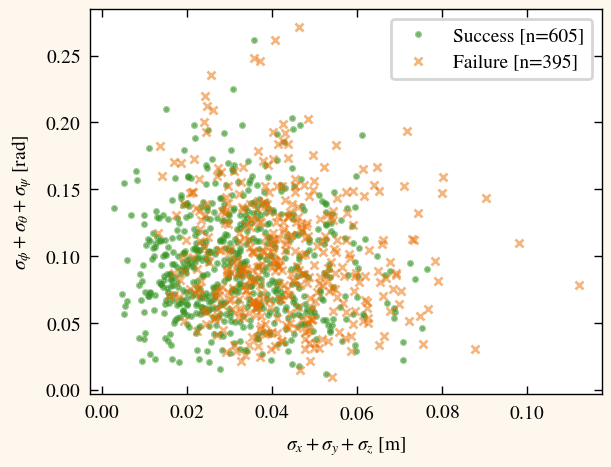

<AxesSubplot: xlabel='$\\sigma_x+\\sigma_y+\\sigma_z$ [m]', ylabel='$\\sigma_\\phi+\\sigma_\\theta+\\sigma_\\psi$ [rad]'>

In [12]:
#Data Scatter

pd_data = ad.data_2_pandas(simdata)


c_fail = 'orange'
c_succ = 'green'

xn = 'sum_s_trans'
yn = 'sum_s_rot'

ax = None

ax = pd_data.loc[pd_data['success'] == 1].plot(x=xn, y=yn, ax =ax, marker='.', c=colours[c_succ], linestyle='', alpha =0.5)
ax = pd_data.loc[pd_data['success'] == 0].plot(x=xn, y=yn, ax=ax, marker='x', c=colours[c_fail], linestyle='', alpha =0.5)
#ax.set_facecolor(colours['background'])

cnt_s = len(pd_data.loc[pd_data['success'] == 1])
cnt_f = len(pd_data.loc[pd_data['success'] == 0])

#ax = pd_data.loc[pd_data['success'] == 0].plot(x=xn, y=yn, ax=ax, marker='x', c=colours[c_fail], linestyle='')
ax.legend([f'Success [n={cnt_s}]',f'Failure [n={cnt_f}]'],frameon=True)

ax.minorticks_off()

plt.xlabel(r'$\sigma_x+\sigma_y+\sigma_z$ [m]')
plt.ylabel(r'$\sigma_\phi+\sigma_\theta+\sigma_\psi$ [rad]')


plt.show()

figsave(ax,'fig_success_scatter_sigma')
